In [33]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml

import pdcast as pdc

while not Path("data") in Path(".").iterdir():
    os.chdir("..")

import mscproject.features as feats
import mscproject.preprocess as pre
import catboost as cb

In [25]:
# Read config.
conf_dict = yaml.safe_load(Path("config/conf.yaml").read_text())

features_path = conf_dict["features_path"]

In [26]:
# Load features for data split.
def load_features(path_root, split):
    features_dir = Path(path_root) / split if split else Path(path_root)
    companies_df = pd.read_parquet(features_dir / "companies.parquet").dropna()
    persons_df = pd.read_parquet(features_dir / "persons.parquet").dropna()
    return companies_df, persons_df

In [42]:
companies_df, persons_df = load_features(features_path, None)

In [43]:
select_cols = list(set(companies_df.columns) & set(persons_df.columns))
# processed_feature_cols = [x for x in select_cols if x.endswith("__processed")]
# raw_feature_cols = [x.split("__processed")[0] for x in processed_feature_cols]
target = "is_anomalous"

entities_df = pd.concat([companies_train_df, persons_train_df], axis=0)[select_cols]

drop_cols = ["id", "name", "component"]

train_df, test_df, valid_df = pre.split_dataset(entities_df)

train_df = train_df.drop(drop_cols, axis=1)
test_df = test_df.drop(drop_cols, axis=1)
valid_df = valid_df.drop(drop_cols, axis=1)

In [46]:
# Create train, test, and valid pools for CatBoost.

cat_features = ["isCompany"]

X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

X_valid = valid_df.drop(target, axis=1)
y_valid = valid_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

train_pool = cb.Pool(
    X_train.to_numpy(),
    y_train.to_numpy(),
    cat_features=cat_features,
    feature_names=X_train.columns.to_list(),
)

valid_pool = cb.Pool(
    X_valid.to_numpy(),
    y_valid.to_numpy(),
    cat_features=cat_features,
    feature_names=X_valid.columns.to_list(),
)

test_pool = cb.Pool(
    X_test.to_numpy(),
    y_test.to_numpy(),
    cat_features=cat_features,
    feature_names=X_test.columns.to_list(),
)

In [51]:
# Create CatBoost model.
clf = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    eval_metric="Accuracy",
    random_seed=42,
)


# Fit model.
clf.fit(
    train_pool,
    eval_set=valid_pool,
    use_best_model=True,
    verbose=50,
)

0:	learn: 0.9233212	test: 0.9248292	best: 0.9248292 (0)	total: 1.77ms	remaining: 176ms
50:	learn: 0.9251891	test: 0.9251546	best: 0.9251546 (50)	total: 80.3ms	remaining: 77.2ms
99:	learn: 0.9277575	test: 0.9264562	best: 0.9267816 (77)	total: 240ms	remaining: 0us

bestTest = 0.9267816466
bestIteration = 77

Shrink model to first 78 iterations.


In [96]:
# Print confusion matrix.
y_pred = clf.predict(test_pool)
print(pd.crosstab(y_test, y_pred, rownames=["Actual"], colnames=["Predicted"]))

Predicted  False  True
Actual                
False       5612     1
True         438   167


In [68]:
# Evaluate model.
_ = clf.eval_metrics(
    test_pool, ["Logloss", "Accuracy", "Precision", "Recall", "AUC"], plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [88]:
# Get Shapley values.
shap_values = clf.get_feature_importance(test_pool, type="ShapValues")[:, 1:]


import shap

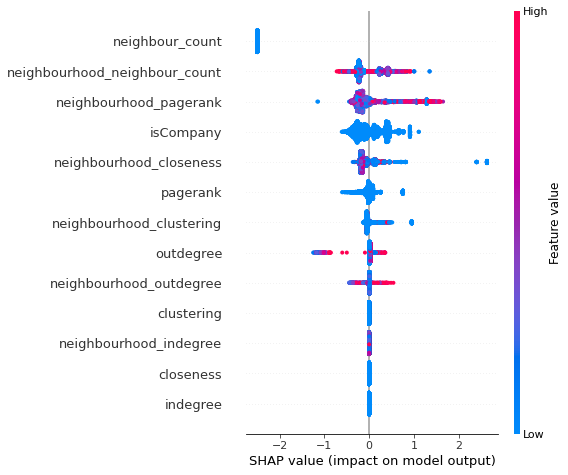

In [91]:
shap.summary_plot(shap_values, X_test)

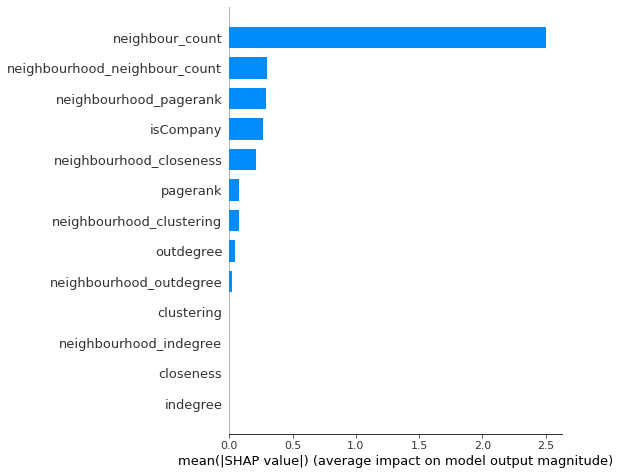

In [92]:
# Plot partial dependence plots.
shap.summary_plot(shap_values, X_test, plot_type="bar")

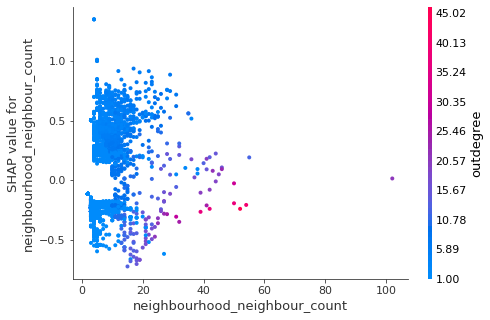

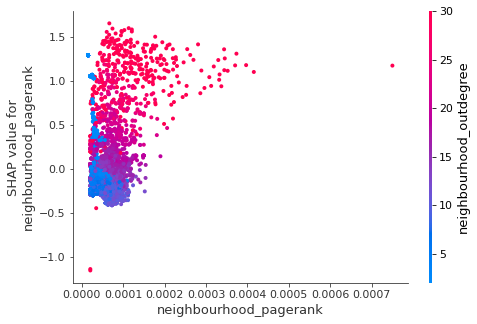

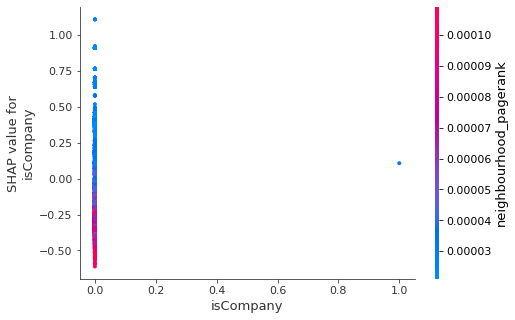

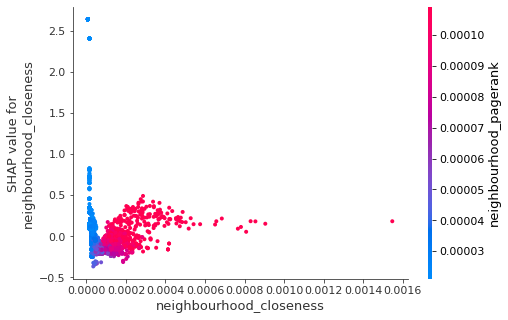

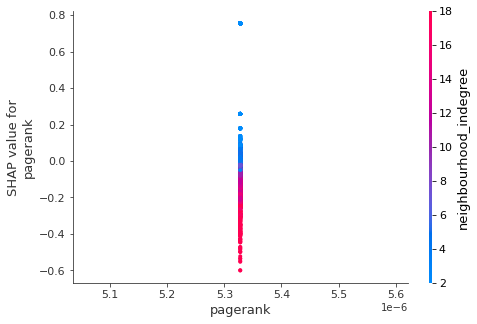

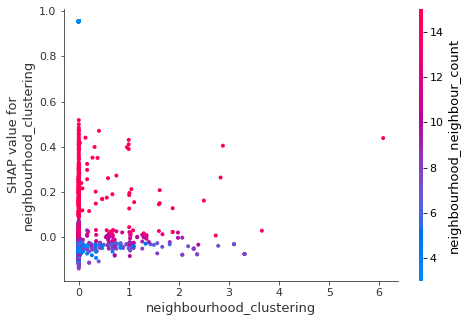

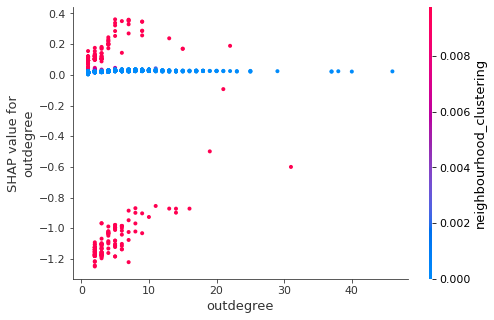

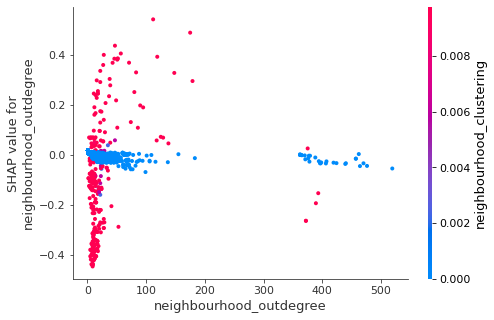

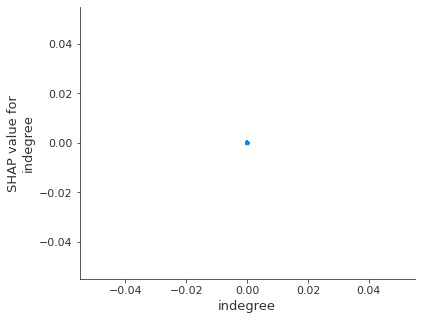

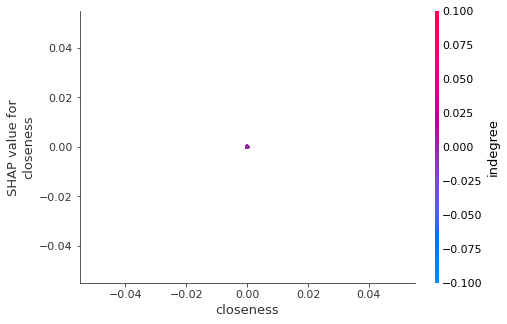

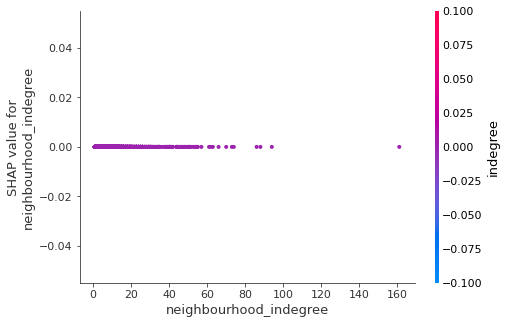

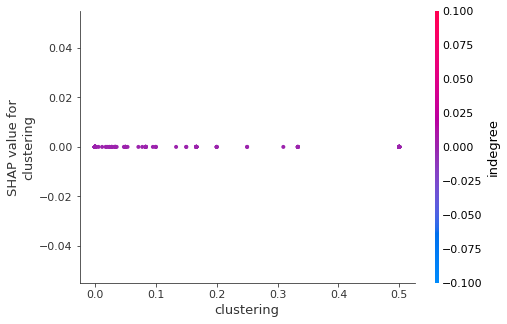

In [94]:
for i in range(1, X_test.shape[1]):
    shap.dependence_plot(f"rank({i})", shap_values, X_test)
    plt.show()